In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [12]:
import icl_draw
reload(icl_draw)
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis

In [13]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap1 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = pklload("./database/01_nh_ghmatch.pickle")
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp)

# mode = 'nh2'
# iout = 797
# repo, rurmode, dp = mode2repo(mode)
# snap2 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
# snap2s = uri.TimeSeries(snap2)
# snap2s.read_iout_avail()
# nout2 = snap2s.iout_avail['iout']
# gal2s = pklload("./database/01_nh2_ghmatch.pickle")
# hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp)

result1s = pklload(f"./database/03_MWA1s.pickle")
# result2s = pklload(f"./database/03_MWA2s.pickle")
pair1s = pklload(f"./database/06_nh_subhalo_pairs.pickle")
# pair2s = pklload(f"./database/06_nh2_subhalo_pairs.pickle")

In [14]:
host1 = result1s[0]
sats = cut_sphere(gal1s, host1['x'], host1['y'], host1['z'], 1.5*host1['r200_code'], both_sphere=True)
sats = sats[sats['id'] != host1['id']]
print(host1['r200_code'])
len(sats)

0.0015380372531741638


96

# Verify whether they are real galaxy or not

In [15]:
pouts = snap1s.iout_avail['iout'][snap1s.iout_avail['age'] >= snap1.age-1]
pouts = pouts[pouts < snap1.iout][::-1]
print(pouts)

for host1 in result1s:
    if(os.path.exists(f"./database/08_nh_scores.pickle")): continue
    sats = cut_sphere(gal1s, host1['x'], host1['y'], host1['z'], 1.5*host1['r200_code'], both_sphere=True)
    sats = sats[sats['id'] != host1['id']]
    print(f"[{host1['id']:04d}] {len(sats)} satellites")

    rrange = host1['r']


    centers = {}
    members = {}
    all_scores = {}
    give_scores = {}
    take_scores = {}

    def get_members(gal):
        global members, snap1s
        if(gal['timestep'] in members.keys()):
            if(gal['id'] in members[gal['timestep']].keys()):
                return members[gal['timestep']][gal['id']]
        else:
            members[gal['timestep']] = {}
        members[gal['timestep']][gal['id']] = uhmi.HaloMaker.read_member_part(snap1s.get_snap(gal['timestep']), gal['id'], galaxy=True, simple=True)
        return members[gal['timestep']][gal['id']]

    if(os.path.exists(f"./database/08_nh_give_scores_host{host1['id']:04d}.pickle")):
        give_scores = pklload(f"./database/08_nh_give_scores_host{host1['id']:04d}.pickle")
        take_scores = pklload(f"./database/08_nh_take_scores_host{host1['id']:04d}.pickle")
    else:
        for ip, pout in tqdm( enumerate(pouts), total=len(pouts) ):
            psnap = snap1s.get_snap(pout)
            # psnap.set_box(sat, 2*rrange)
            pgals = uhmi.HaloMaker.load(psnap, galaxy=True, double_precision=dp)
            for sat in sats:
                if(sat['id'] in centers.keys()):
                    center = centers[sat['id']]
                else:
                    center = [sat['x'], sat['y'], sat['z']]
                    centers[sat['id']] = center
                my_member = get_members(sat)
                pneighbors = cut_box(pgals, *center, rrange)


                if(len(pneighbors)==0): continue

                give_score = np.zeros(len(pneighbors))
                take_score = np.zeros(len(pneighbors))
                for i, pg in enumerate(pneighbors):
                    pmember = get_members(pg)
                    intersect = np.sum( isin(pmember, my_member, assume_unique=True) )
                    give_score[i] = intersect / len(my_member) / 2
                    take_score[i] = intersect / len(pmember) / 2
                all_score = give_score * take_score
                
                argmax_all = np.argmax(all_score)
                argmax_give = np.argmax(give_score)
                argmax_take = np.argmax(take_score)
                if(not sat['id'] in all_scores.keys()):
                    all_scores[sat['id']] = np.zeros(len(pouts))
                    give_scores[sat['id']] = np.zeros(len(pouts))
                    take_scores[sat['id']] = np.zeros(len(pouts))
                
                all_scores[sat['id']][ip] = pneighbors['id'][argmax_all] + all_score[argmax_all]
                # if(sat['id']==178): print(pneighbors['id'][argmax_all] + all_score[argmax_all], all_score[argmax_all])
                # if(sat['id']==178): print(give_score)
                give_scores[sat['id']][ip] = pneighbors['id'][argmax_give] + give_score[argmax_give]
                take_scores[sat['id']][ip] = pneighbors['id'][argmax_take] + take_score[argmax_take]
                centers[sat['id']] = [ pneighbors['x'][argmax_all], pneighbors['y'][argmax_all], pneighbors['z'][argmax_all] ]
                
    pklsave(give_scores, f"./database/08_nh_give_scores_host{host1['id']:04d}.pickle", overwrite=True)
    pklsave(take_scores, f"./database/08_nh_take_scores_host{host1['id']:04d}.pickle", overwrite=True)

score_results = {}
score_results['give'] = {}
score_results['take'] = {}
for host1 in result1s:
    give_scores = pklload(f"./database/08_nh_give_scores_host{host1['id']:04d}.pickle")
    take_scores = pklload(f"./database/08_nh_take_scores_host{host1['id']:04d}.pickle")
    score_results['give'][host1['id']] = give_scores
    score_results['take'][host1['id']] = take_scores

    os.remove(f"./database/08_nh_give_scores_host{host1['id']:04d}.pickle")
    os.remove(f"./database/08_nh_take_scores_host{host1['id']:04d}.pickle")
pklsave(score_results, f"./database/08_nh_scores.pickle", overwrite=True)

[1025 1024 1023 1022 1021 1020 1019 1018 1017 1016 1015 1014 1013 1012
 1011 1010 1009 1008 1007 1006 1005 1004 1003 1002 1001 1000  999  998
  997  996  995  994  993  992  991  990  989  988  987  986  985  984
  983  982  981  980  979  978  977  976  975  974  973  972  971  970
  969  968  967  966  965  964  963  962  961  960  959  958  957  956
  955  954  953  952  951  950  949  948  947  946  945  944  943  942
  941  940  939  938  937  936  935  934  933  932  931  930  929  928
  927  926  925  924  923  922  921  920  919  918  917  916  915  914
  913  912  911  910  909  908  907  906  905  904  903  902  901  900
  899]
[0001] 96 satellites
[0002] 156 satellites


  4%|▍         | 5/127 [01:40<40:58, 20.15s/it]


KeyboardInterrupt: 

In [ ]:
from matplotlib.colors import Normalize
cmap = plt.cm.jet
norm = Normalize(vmin=np.min(pouts), vmax=np.max(pouts))

# For colorbar axis
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

for host1 in result1s:
    give_scores = score_results['give'][host1['id']]
    take_scores = score_results['take'][host1['id']]
    for target_id in tqdm( give_scores.keys() ):
        if(not os.path.exists(f"./database/photo/08_fragmentation/NH_host{host1['id']:04d}_sat{target_id:04d}.png")):
            fig, axes = plt.subplots(1,2, figsize=(8,4))
            ax = axes[1]
            give_percents = np.zeros(len(pouts))
            take_percents = np.zeros(len(pouts))
            i = 0
            xs = np.zeros(len(pouts)); ys = np.zeros(len(pouts))
            for ip, a,b in zip(pouts, give_scores[target_id], take_scores[target_id]):
                give_percent = (a%1)*200
                take_percent = (b%1)*200
                give_percents[i] = give_percent
                take_percents[i] = take_percent
                give_id = int(a//1)
                take_id = int(b//1)
                # print(f"{ip:04d}\tgive {give_percent:.2f}% & take {take_percent:.2f}%")

                isnap = snap1s.get_snap(ip)
                igals = uhmi.HaloMaker.load(isnap, galaxy=True, double_precision=dp)
                igal = igals[give_id-1]
                xs[i] = igal['x']; ys[i] = igal['y']
                # ax.scatter(igal['x'],igal['y'], s=1, color='k')
                cir = plt.Circle((igal['x'],igal['y']), igal['r'], color=cmap(norm(ip)), fill=False, lw=0.5)
                ax.add_patch(cir)
                i+=1
            ax.plot(xs, ys, color='k', lw=0.5)
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            lx = xlim[1]-xlim[0]; cx = np.mean(xlim)
            ly = ylim[1]-ylim[0]; cy = np.mean(ylim)
            lside = max(lx, ly)*1.1
            ax.set_xlim(cx-lside/2, cx+lside/2)
            ax.set_ylim(cy-lside/2, cy+lside/2)

            # Make horizontal colorbar below
            cax = make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.05)
            cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation="horizontal")
            cb.set_label('Snapshot No.')
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title("Postion & Radius by Snapshot")
            add_scalebar(ax, isnap.unit_l, color='k')

            # ax.axis('equal')

            ax = axes[0]
            ax.plot(pouts, give_percents, label='give')
            ax.plot(pouts, take_percents, label='take')
            ax.set_ylim(-2,102)
            ax.set_xlim(np.min(pouts), np.max(pouts))
            ax.legend()
            ax.set_title("Shared particle percentage")

            plt.subplots_adjust(wspace=0.05)
            plt.savefig(f"./database/photo/08_fragmentation/NH_host{host1['id']:04d}_sat{target_id:04d}.png", dpi=300, facecolor='w')
            plt.close()

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:00<00:00, 1350.37it/s]


In [9]:
star = None; dm = None; cell = None
rband = None

178 1.0
220 0.9745644451962221
226 0.7673473337849614
510 0.962726138490325
575 0.7979274611398068
606 0.31815528312881725
1115 0.7702702702702027
1116 0.989189189189176
1117 0.6140724946694718
1122 0.7221764220939804
1144 0.7250936329587603
2967 0.32298136645931663


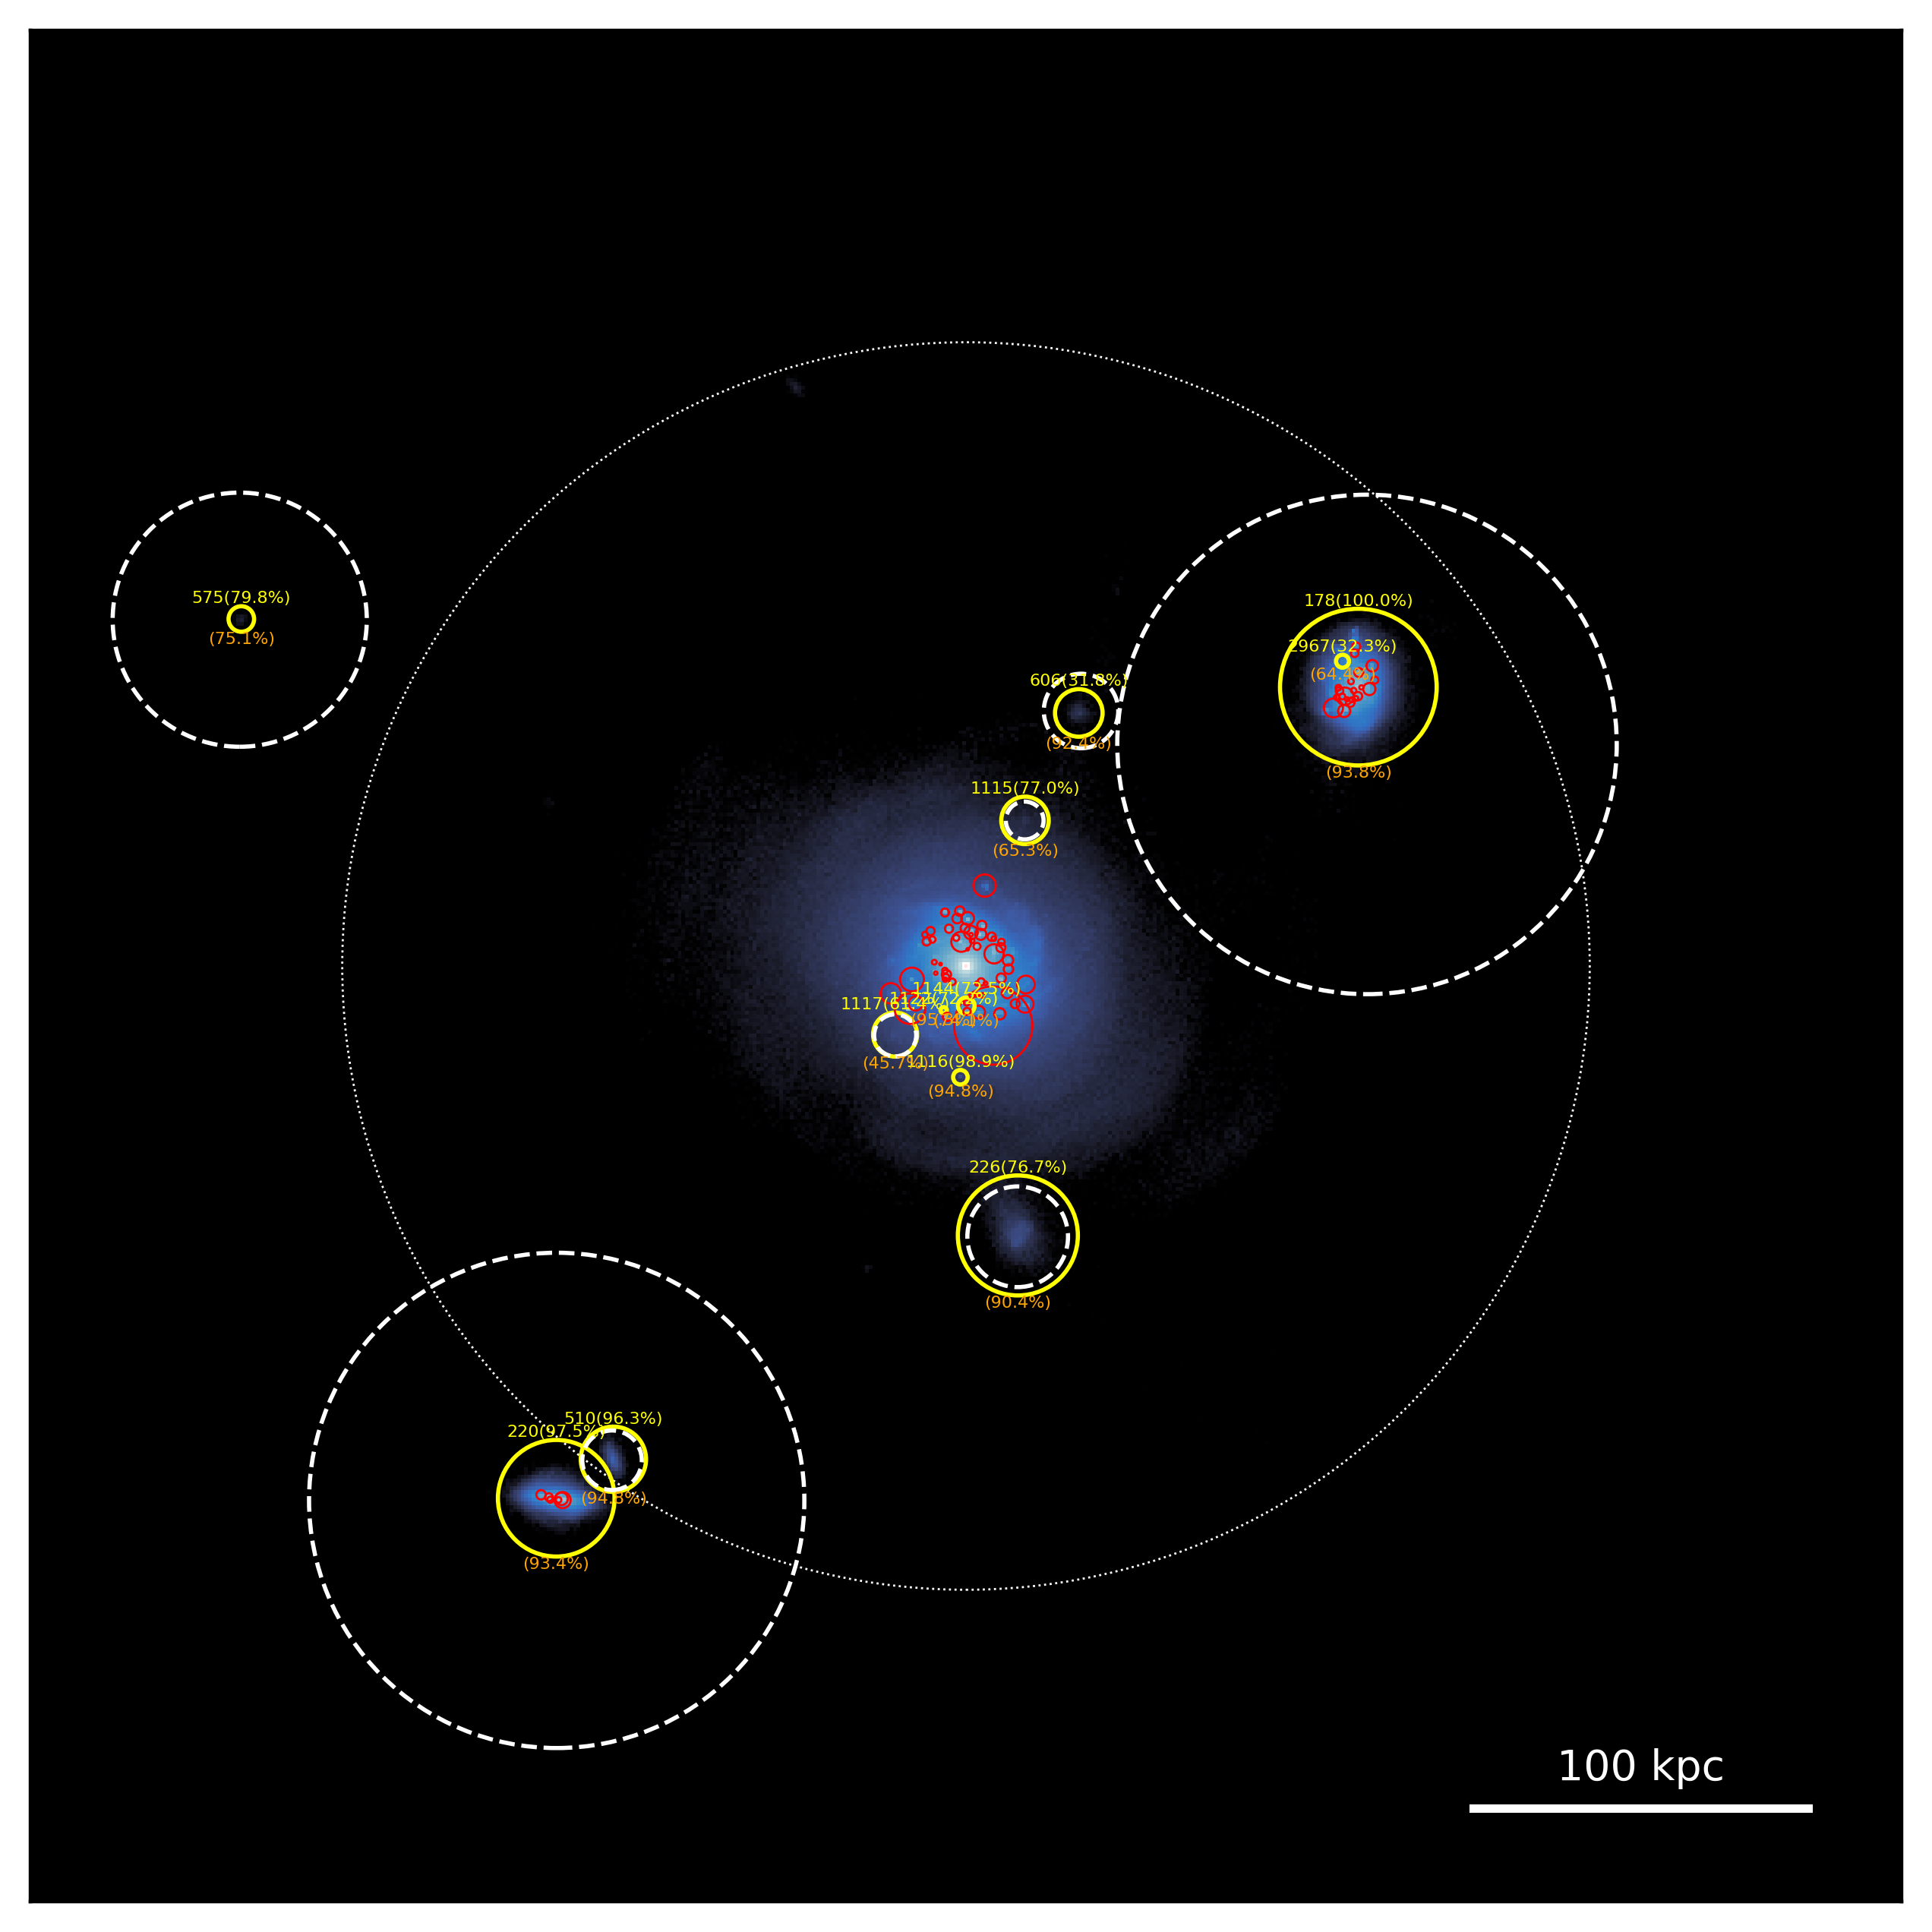

In [10]:
for MWA1 in result1s:
    dic = pair1s[MWA1['id']]
    pairs = dic['pair']
    all_sats = dic['all_sat']
    all_subs = dic['all_sub']

    snap1.set_box_halo(MWA1, 1.5, radius_name='r200_code')
    if(star is None): star = uri.Particle( pklload(f"./database/parts/nh_star_{MWA1['id']:04}.pickle"), snap1)
    if(dm is None): dm = uri.Particle( pklload(f"./database/parts/nh_dm_{MWA1['id']:04}.pickle"), snap1)
    if(cell is None): cell = uri.Cell( pklload(f"./database/parts/nh_cell_{MWA1['id']:04}.pickle"), snap1 )
    if(rband is None): rband = measure_luminosity(star, 'SDSS_r')

    fig, ax = fancy_axis(figsize=(8, 8), dpi=400)
    
    painter.draw_partmap(star, box=snap1.box, ax=ax, cmap=cmr.arctic, qscale=5, weights=rband)

    cir = circle(MWA1, rname='r200_code', ls=':', alpha=1, color='w')
    ax.add_patch(cir)

    pair_sat = [pair[1] for pair in pairs]
    for sat in sats:
        temp = 2*np.median( take_scores[sat['id']]%1 )
        color = 'yellow' if(temp>0.3) else 'red'
        lw = 1 if(temp>0.3) else 0.5
        cir = circle(sat, rname='r', color=color, alpha=1, lw=lw)
        ax.add_patch(cir)
        if(temp>0.3):
            if(sat['id'] in pair_sat):
                where = np.where(np.array(pair_sat)==sat['id'])[0][0]
                sub = hal1s[pairs[where][0]-1]
                cir = circle(sub, rname='rvir', ls='--', color='w', alpha=1, lw=lw)
                ax.add_patch(cir)
            ax.text(sat['x'], sat['y']+sat['r'], f"{sat['id']}({100*temp:.1f}%)", color='yellow', fontsize=4, ha='center', va='bottom')
            print(sat['id'], temp)
            temp = 2*np.median( give_scores[sat['id']]%1 )
            ax.text(sat['x'], sat['y']-sat['r'], f"({100*temp:.1f}%)", color='orange', fontsize=4, ha='center', va='top')
    # sats = gal1s[[pair[1]-1 for pair in pairs]]
    # subs = hal1s[[pair[0]-1 for pair in pairs]]
    # for sat,sub in zip(sats, subs):
    #     cir = circle(sat, rname='r')
    #     ax.add_patch(cir)
    #     cir = circle(sub, rname='rvir', ls='--')
    #     ax.add_patch(cir)
    add_scalebar(ax, snap1.unit_l)

    plt.show()
    plt.close()
    break